<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#%load_ext autoreload
%matplotlib inline
#%autoreload 2

import sys
from IPython.display import clear_output
# sys.path.append('/eos/user/e/efthymio/Projects/LHCLumi/LHCLumiAnalysis/')
#for p in sys.path:
#    print (p)

import os
import cl2pd
from cl2pd import importData
pd = importData.pd
cals = importData.cals

# import LHCPerformanceTools.LHC_WSData as WSData
# WS = WSData.LHCWSData()

import itertools
import operator
import numpy as np
import glob
import pickle
import gzip
import time

import matplotlib.pyplot as plt
import scipy
import pandas as pd

from scipy.stats.stats import pearsonr 
from itertools import cycle
pd.options.mode.chained_assignment = None  # default='warn'


# get_ipython().magic('matplotlib inline')

# --- Definitions

BASEWSDIR = '/eos/project/l/lhc-profiles-lumi/WS/2018'
RAWWSDIR = '{}/rawdata'.format(BASEWSDIR)
PROCWSDIR = '{}/procdata'.format(BASEWSDIR)

MASS_PROTON = 938.27231 #MeV

# Extract Data and Do Fitting

In [3]:
fno = 6699
fname = '/eos/project/l/lhc-profiles-lumi/WS/2018/procdata/fill_{}/fill_{}_wsprof_exp.pkl'.format(fno, fno)
with open(fname,'rb') as fin:
    scandf = pd.read_pickle(fin)

Convert all data to numpy arrays.

In [4]:
scandf['PROF_DATA_IN'] = scandf['PROF_DATA_IN'].apply(lambda x: np.array(x))
scandf['PROF_DATA_OUT'] = scandf['PROF_DATA_OUT'].apply(lambda x: np.array(x))
scandf['PROF_POSITION_IN'] = scandf['PROF_POSITION_IN'].apply(lambda x: np.array(x))
scandf['PROF_POSITION_OUT'] = scandf['PROF_POSITION_OUT'].apply(lambda x: np.array(x))

## Fit Gaussian Parameters to Get Width

Fit data to

$ f(x) = ae^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2}$

and use $\sigma$ as beam width.

In [5]:
def gaus(x, sigma, x0, a, y0):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + y0

In [6]:
def fit_to_gauss(df_row, wire_movement): #wire movement is "IN" or "OUT:

    x = df_row['PROF_POSITION_'+wire_movement]
    y = df_row['PROF_DATA_'+wire_movement]
    
    # INITIAL GUESSES FOR FIT
    ypeak = max(y) 
    xpeak = x[y.argmax()]
    half_max = np.abs(y-ypeak/2).argmin()
    std_approx = np.abs(x[half_max] - xpeak)
    
    if ypeak>300:
        popt,pcov = scipy.optimize.curve_fit(gaus,x,y,p0=[std_approx, xpeak, ypeak, 0])
        sigma, mean, ampl, yoff = popt 
    else:
        mean = ampl = yoff = 0
        sigma = None
        
    return sigma

In [7]:
scandf['BEAM_WIDTH_IN'] = scandf.apply(fit_to_gauss, axis='columns', args=('IN',))
scandf['BEAM_WIDTH_OUT'] = scandf.apply(fit_to_gauss, axis='columns', args=('OUT',))

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Show that intensity is Always Decreasing

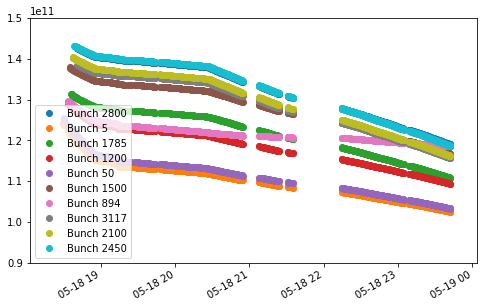

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
bunches = scandf.dropna()['BUNCH'].unique()
beam ='B1'

plot_df = scandf[(scandf['BEAM'] == beam)]

for i, bunch in enumerate(bunches):
    if i == 10:
        break
    plot_df[plot_df['BUNCH']==bunch]['INTENSITY'].plot(linestyle = "", marker = "o", ax=ax, label='Bunch '+str(bunch))
    
plt.ylim([0.9*10**11, 1.5*10**11])
plt.legend()
plt.show()

# Comparing Intensity to Area Under Beam Profile

Here we use the IN measurements to get measurements for the intensity.

## Get Area Under the Beam Profile (Should be Proportional to Intensity)

Need to subtract baseline

In [9]:
def get_intensity_from_bp(df_row):
    beam_prof = np.array(df_row['PROF_DATA_IN'])
    baseline = np.average(beam_prof[0:50])
    beam_prof = beam_prof - baseline
    return beam_prof.sum()

scandf['INTENSITY_FROM_BP'] = scandf.apply(get_intensity_from_bp, axis='columns')

## The Plots

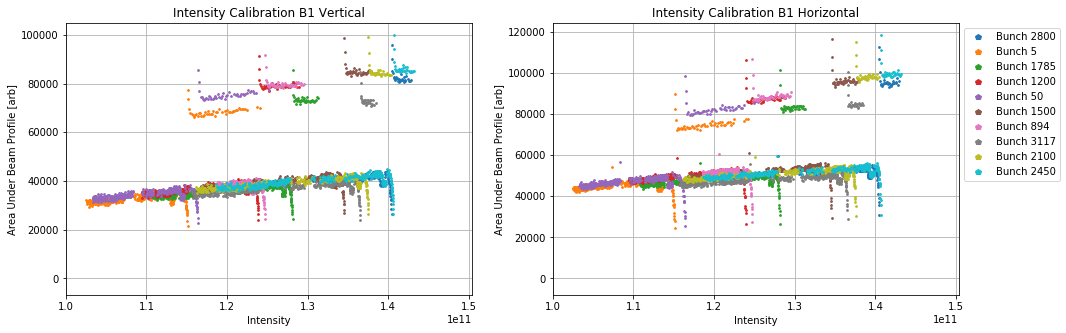

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

beam = 'B1'
bunches = scandf.dropna()['BUNCH'].unique()

for i, bunch in enumerate(bunches):
    
    if i == 10:
        break
    
    x1 = np.array(scandf[(scandf['PLANE']=='V') & (scandf['BUNCH'] == bunch) & (scandf['BEAM'] == beam)]['INTENSITY'])
    y1 = np.array(scandf[(scandf['PLANE']=='V') & (scandf['BUNCH'] == bunch) & (scandf['BEAM'] == beam)]['INTENSITY_FROM_BP'])
    x2 = np.array(scandf[(scandf['PLANE']=='H') & (scandf['BUNCH'] == bunch) & (scandf['BEAM'] == beam)]['INTENSITY'])
    y2 = np.array(scandf[(scandf['PLANE']=='H') & (scandf['BUNCH'] == bunch) & (scandf['BEAM'] == beam)]['INTENSITY_FROM_BP'])

    axes[0].plot(x1, y1, 'p', markersize=2)
    axes[1].plot(x2, y2, 'p', label='Bunch '+str(bunch), markersize=2)

props1 = {'title': 'Intensity Calibration ' + beam + ' Vertical',
        'xlabel': 'Intensity',
        'ylabel': 'Area Under Beam Profile [arb]' }

props2 = {'title': 'Intensity Calibration ' + beam + ' Horizontal',
        'xlabel': 'Intensity',
        'ylabel': 'Area Under Beam Profile [arb]'}

axes[0].set(**props1)
axes[1].set(**props2)
axes[1].legend(loc = 'best', ncol=1, markerscale=3)
axes[0].grid(), axes[1].grid()

axes[0].set_xlim(left = 1.0*10**11)
axes[1].set_xlim(left = 1.0*10**11)

bunch_legend = axes[1].legend(loc='upper left', bbox_to_anchor = (1.0, 1.0), ncol = 1, markerscale=3)
plt.show()

Note that intensity is steadily decreasing throughout this fill. As such, the plots should be read from right to left for time evolution. A common effect occurs for each bunch in the following order:

* SETUP-PRERAMP: The relationship is approximately linear; the intensity and area under the beam profile are steadily decreasing. (The lines on the upper half of the plots).
* RAMP: The area under the beam profile quickly increases, 'jumps down' the plot, then quickly increases again. (The vertical 'hairs' on the plots).
* FLATTOP-SQUEEZE: Data points are still contained in the 'hairs' at the bottom of the plot where the area under the beam profile is increasing quickly.
* ADJUST-RAMPDOWN: The relationship is approximately linear; the intensity and area under the beam profile are steadily decreasing. (The lines on the lower half of the plots).



### Examines Subset of Data Above

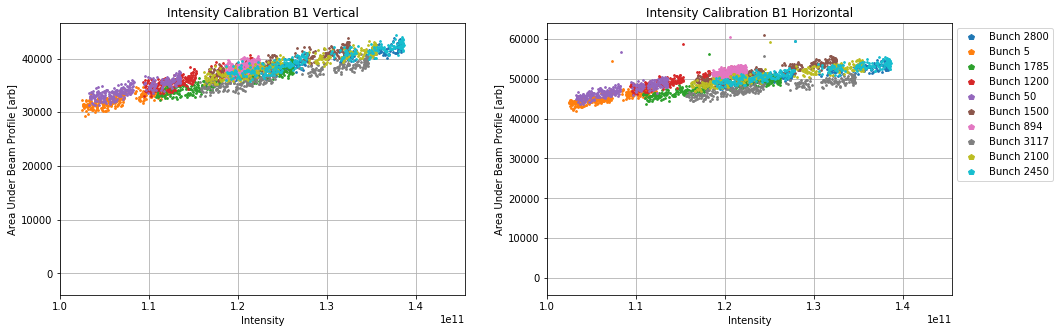

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16,5))

beam = 'B1'

phases = [u'ADJUST', u'STABLE', u'BEAMDUMP', u'RAMPDOWN']
plot_df = scandf[scandf['FMODE'].isin(phases)]
bunches = plot_df.dropna()['BUNCH'].unique()

for i, bunch in enumerate(bunches):
    
    if i == 10:
        break
    
    x1 = np.array(plot_df[(plot_df['PLANE']=='V') & (plot_df['BUNCH'] == bunch) & (plot_df['BEAM'] == beam)]['INTENSITY'])
    y1 = np.array(plot_df[(plot_df['PLANE']=='V') & (plot_df['BUNCH'] == bunch) & (plot_df['BEAM'] == beam)]['INTENSITY_FROM_BP'])
    x2 = np.array(plot_df[(plot_df['PLANE']=='H') & (plot_df['BUNCH'] == bunch) & (plot_df['BEAM'] == beam)]['INTENSITY'])
    y2 = np.array(plot_df[(plot_df['PLANE']=='H') & (plot_df['BUNCH'] == bunch) & (plot_df['BEAM'] == beam)]['INTENSITY_FROM_BP'])

    axes[0].plot(x1, y1, 'p', markersize=2)
    axes[1].plot(x2, y2, 'p', label='Bunch '+str(bunch), markersize=2)

props1 = {'title': 'Intensity Calibration ' + beam + ' Vertical',
        'xlabel': 'Intensity',
        'ylabel': 'Area Under Beam Profile [arb]' }

props2 = {'title': 'Intensity Calibration ' + beam + ' Horizontal',
        'xlabel': 'Intensity',
        'ylabel': 'Area Under Beam Profile [arb]'}

axes[0].set(**props1)
axes[1].set(**props2)
axes[1].legend(loc = 'best', ncol=1, markerscale=3)
axes[0].grid(), axes[1].grid()

axes[0].set_xlim(left = 1.0*10**11)
axes[1].set_xlim(left = 1.0*10**11)

bunch_legend = axes[1].legend(loc='upper left', bbox_to_anchor = (1.0, 1.0), ncol = 1, markerscale=3)
plt.show()